In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

results = pd.read_parquet("./sampling_scaling_rtt.gzip")

# only look at the empirical-high timing model (ground truth)
results = results[results["timing_model"] == "empirical-high"].copy()
results["timing_model"] = results["timing_model"].cat.remove_unused_categories()
results["sampling_scheme"] = results["sampling_scheme"].astype(
    pd.CategoricalDtype(
        ['greedy',
         'ideal',
         'adaptive-empirical',
         'adaptive-theoretical-exgaussian',
         'adaptive-theoretical-rayleigh',
         'adaptive-fitted-naive-exgaussian',
         'adaptive-fitted-naive-rayleigh',
         'adaptive-power-empirical',
         'adaptive-power-theoretical-exgaussian',
         'adaptive-power-theoretical-rayleigh',
         'adaptive-power-fitted-naive-exgaussian',
         'adaptive-power-fitted-naive-rayleigh',
         'periodic-1.0s',
         'periodic-3.0s',
         'periodic-5.0s',
         'hold-1.0s',
         'hold-3.0s',
         'hold-5.0s'], ordered=True
        )
)

def _classify_sampling(s: str) -> str:
    ssplit = s.split("-")
    if len(ssplit) > 1:
        if ssplit[0] == "adaptive":
            if ssplit[1] == "power":
                return "adaptive-energy"
            else:
                return "adaptive-ttf"
        return ssplit[0]
    else:
        return "reference"

results["sampling_class"] = (
    results["sampling_scheme"]
    .apply(_classify_sampling)
    .astype(pd.CategoricalDtype(["adaptive-energy", "adaptive-ttf", "reference", "periodic", "hold"]))
)

# remove the realistic-low, high adaptive schemes
# results = results[~results["sampling_scheme"].str.endswith("low") & ~results["sampling_scheme"].str.endswith("high")]
results["sampling_scheme"] = results["sampling_scheme"].cat.remove_unused_categories()

results

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,repetition,energy,cumulative_energy,timing_model,sampling_scheme,sampling_class
0,2.0,1,2.000000,10.215511,13.248493,3.032983,1.032983,6,13.248493,6,50,0.504727,0.504727,empirical-high,adaptive-empirical,adaptive-ttf
1,2.0,2,3.032983,2.864649,6.452861,3.588212,1.588212,2,19.701354,8,50,0.198793,0.703520,empirical-high,adaptive-empirical,adaptive-ttf
2,2.0,3,3.588212,6.356987,9.446737,3.089750,1.089750,3,29.148090,11,50,0.294701,0.998221,empirical-high,adaptive-empirical,adaptive-ttf
3,2.0,4,3.089750,6.268031,9.510855,3.242825,1.242825,3,38.658946,14,50,0.295663,1.293884,empirical-high,adaptive-empirical,adaptive-ttf
4,2.0,5,3.242825,4.558994,7.771244,3.212251,1.212251,2,46.430190,16,50,0.218569,1.512453,empirical-high,adaptive-empirical,adaptive-ttf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295995,1.0,116,5.052554,4.453674,6.000000,1.546326,0.546326,1,1126.000000,202,56,0.111000,21.132000,empirical-high,periodic-5.0s,periodic
1295996,1.0,117,1.546326,6.513625,11.000000,4.486375,3.486375,2,1137.000000,204,56,0.207000,21.339000,empirical-high,periodic-5.0s,periodic
1295997,1.0,118,4.486375,2.226313,6.000000,3.773687,2.773687,1,1143.000000,205,56,0.111000,21.450000,empirical-high,periodic-5.0s,periodic
1295998,1.0,119,3.773687,13.110628,16.000000,2.889372,1.889372,3,1159.000000,208,56,0.303000,21.753000,empirical-high,periodic-5.0s,periodic


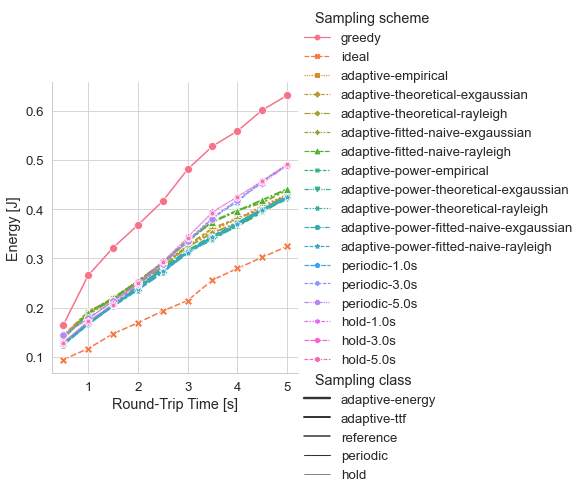

In [100]:
fg = sns.relplot(
    kind="line",
    errorbar=None,
    data=results.rename(columns={"sampling_scheme": "Sampling scheme", "sampling_class": "Sampling class"}),
    x="rtt",
    y="energy",
    hue="Sampling scheme",
    style="Sampling scheme",
    size="Sampling class",
    markers=True,
    aspect=1,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Energy [J]")
# fg.legend.set_title("Sampling Scheme")
plt.show()

In [3]:
energy_at_max_rtt = (
    results[results["rtt"] == results["rtt"].max()]
    .groupby("sampling_scheme")
    ["energy"]
    .mean()
    .sort_values()
)
energy_at_max_rtt

sampling_scheme
ideal                                     0.324733
adaptive-power-theoretical-exgaussian     0.421568
adaptive-power-empirical                  0.424228
adaptive-power-fitted-naive-exgaussian    0.424256
adaptive-power-fitted-naive-rayleigh      0.424471
adaptive-power-theoretical-rayleigh       0.424818
adaptive-theoretical-exgaussian           0.427917
adaptive-empirical                        0.430238
adaptive-theoretical-rayleigh             0.430378
adaptive-fitted-naive-exgaussian          0.439700
adaptive-fitted-naive-rayleigh            0.441404
hold-1.0s                                 0.487860
periodic-5.0s                             0.489000
periodic-1.0s                             0.489600
hold-3.0s                                 0.491070
hold-5.0s                                 0.491940
periodic-3.0s                             0.492240
greedy                                    0.632190
Name: energy, dtype: float64

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('+').  Matplotlib is ignoring

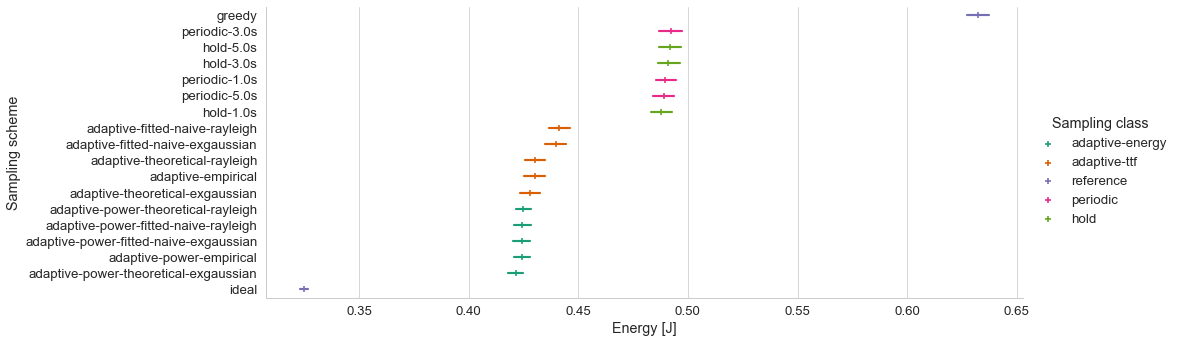

In [92]:
fg = sns.catplot(
    kind="point",
    errorbar=("ci", 95),
    data=results[results["rtt"] == results["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="energy",
    join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    markers="+",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [49]:
import numpy as np

energies_maxrtt = results.loc[(results["rtt"] == results["rtt"].max())].groupby(["sampling_class", "sampling_scheme"])["energy"].describe(percentiles=[])
energies_maxrtt["var"] = np.square(energies_maxrtt["std"])
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                            
adaptive-energy adaptive-power-empirical                7200.0  0.424228   
                adaptive-power-theoretical-exgaussian   7200.0  0.421568   
                adaptive-power-theoretical-rayleigh     7200.0  0.424818   
                adaptive-power-fitted-naive-exgaussian  7200.0  0.424256   
                adaptive-power-fitted-naive-rayleigh    7200.0  0.424471   
adaptive-ttf    adaptive-empirical                      7200.0  0.430238   
                adaptive-theoretical-exgaussian         7200.0  0.427917   
                adaptive-theoretical-rayleigh           7200.0  0.430378   
                adaptive-fitted-naive-exgaussian        7200.0  0.439700   
                adaptive-fitted-naive-rayleigh          7200.0  0.441404   
reference       greedy                                  7200.0  0.632190   
                ideal                                   7200.0  0.324733   
periodic        periodic-1.0s                           7200.0  0.489600   
                periodic-3.0s                           7200.0  0.492240   
                periodic-5.0s                           7200.0  0.489000   
hold            hold-1.0s                               7200.0  0.487860   
                hold-3.0s                               7200.0  0.491070   
                hold-5.0s                               7200.0  0.491940   

                                                             std       min  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.157702  0.240207   
                adaptive-power-theoretical-exgaussian   0.155482  0.346592   
                adaptive-power-theoretical-rayleigh     0.158584  0.241626   
                adaptive-power-fitted-naive-exgaussian  0.171950  0.343516   
                adaptive-power-fitted-naive-rayleigh    0.174857  0.343516   
adaptive-ttf    adaptive-empirical                      0.198583  0.281526   
                adaptive-theoretical-exgaussian         0.192839  0.235213   
                adaptive-theoretical-rayleigh           0.199012  0.285366   
                adaptive-fitted-naive-exgaussian        0.201191  0.234761   
                adaptive-fitted-naive-rayleigh          0.204650  0.234761   
reference       greedy                                  0.210921  0.432000   
                ideal                                   0.069156  0.216005   
periodic        periodic-1.0s                           0.212861  0.291000   
                periodic-3.0s                           0.216650  0.291000   
                periodic-5.0s                           0.212384  0.291000   
hold            hold-1.0s                               0.205616  0.291000   
                hold-3.0s                               0.219199  0.291000   
                hold-5.0s                               0.216060  0.291000   

                                                             50%       max  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.376275  1.479386   
                adaptive-power-theoretical-exgaussian   0.376276  2.105418   
                adaptive-power-theoretical-rayleigh     0.382532  1.492401   
                adaptive-power-fitted-naive-exgaussian  0.361866  1.452548   
                adaptive-power-fitted-naive-rayleigh    0.361866  2.511475   
adaptive-ttf    adaptive-empirical                      0.338821  2.254147   
                adaptive-theoretical-exgaussian         0.338821  2.669493   
                adaptive-theoretical-rayleigh           0.343615  1.639615   
                adaptive-fitted-naive-exgaussian        0.327779  2.255805   
                adaptive-fitted-naive-rayleigh          0.327779  2.054381   
reference       greedy                 

In [59]:
import scipy.stats as stats
ix = pd.IndexSlice

# calculate the 95% CI for the difference between the means wrt to the ideal case
ideal_mean = energies_maxrtt.loc[ix["reference", "ideal"], "mean"]
ideal_var = energies_maxrtt.loc[ix["reference", "ideal"], "var"]
sample_size = results[(results["rtt"] == results["rtt"].max())].groupby("sampling_scheme").size().unique().take(0)

mean_diff = energies_maxrtt["mean"] - ideal_mean
t_critical = stats.t.ppf(q=0.95, df=sample_size + sample_size - 2)
spooled_variance = (((sample_size - 1) * np.square(energies_maxrtt["var"])) + ((sample_size - 1) * np.square(ideal_var))) / (sample_size + sample_size - 2)

t_factor = t_critical * np.sqrt(2 * np.square(spooled_variance) / sample_size)

energies_maxrtt["mean_diff_ideal"] = mean_diff
energies_maxrtt["mean_diff_ideal_95ci"] = t_factor

energies_maxrtt["mean_diff_ideal_percent"] = mean_diff / ideal_mean
energies_maxrtt["mean_diff_ideal_95ci_percent"] = t_factor / ideal_mean
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                            
adaptive-energy adaptive-power-empirical                7200.0  0.424228   
                adaptive-power-theoretical-exgaussian   7200.0  0.421568   
                adaptive-power-theoretical-rayleigh     7200.0  0.424818   
                adaptive-power-fitted-naive-exgaussian  7200.0  0.424256   
                adaptive-power-fitted-naive-rayleigh    7200.0  0.424471   
adaptive-ttf    adaptive-empirical                      7200.0  0.430238   
                adaptive-theoretical-exgaussian         7200.0  0.427917   
                adaptive-theoretical-rayleigh           7200.0  0.430378   
                adaptive-fitted-naive-exgaussian        7200.0  0.439700   
                adaptive-fitted-naive-rayleigh          7200.0  0.441404   
reference       greedy                                  7200.0  0.632190   
                ideal                                   7200.0  0.324733   
periodic        periodic-1.0s                           7200.0  0.489600   
                periodic-3.0s                           7200.0  0.492240   
                periodic-5.0s                           7200.0  0.489000   
hold            hold-1.0s                               7200.0  0.487860   
                hold-3.0s                               7200.0  0.491070   
                hold-5.0s                               7200.0  0.491940   

                                                             std       min  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.157702  0.240207   
                adaptive-power-theoretical-exgaussian   0.155482  0.346592   
                adaptive-power-theoretical-rayleigh     0.158584  0.241626   
                adaptive-power-fitted-naive-exgaussian  0.171950  0.343516   
                adaptive-power-fitted-naive-rayleigh    0.174857  0.343516   
adaptive-ttf    adaptive-empirical                      0.198583  0.281526   
                adaptive-theoretical-exgaussian         0.192839  0.235213   
                adaptive-theoretical-rayleigh           0.199012  0.285366   
                adaptive-fitted-naive-exgaussian        0.201191  0.234761   
                adaptive-fitted-naive-rayleigh          0.204650  0.234761   
reference       greedy                                  0.210921  0.432000   
                ideal                                   0.069156  0.216005   
periodic        periodic-1.0s                           0.212861  0.291000   
                periodic-3.0s                           0.216650  0.291000   
                periodic-5.0s                           0.212384  0.291000   
hold            hold-1.0s                               0.205616  0.291000   
                hold-3.0s                               0.219199  0.291000   
                hold-5.0s                               0.216060  0.291000   

                                                             50%       max  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.376275  1.479386   
                adaptive-power-theoretical-exgaussian   0.376276  2.105418   
                adaptive-power-theoretical-rayleigh     0.382532  1.492401   
                adaptive-power-fitted-naive-exgaussian  0.361866  1.452548   
                adaptive-power-fitted-naive-rayleigh    0.361866  2.511475   
adaptive-ttf    adaptive-empirical                      0.338821  2.254147   
                adaptive-theoretical-exgaussian         0.338821  2.669493   
                adaptive-theoretical-rayleigh           0.343615  1.639615   
                adaptive-fitted-naive-exgaussian        0.327779  2.255805   
                adaptive-fitted-naive-rayleigh          0.327779  2.054381   
reference       greedy                 

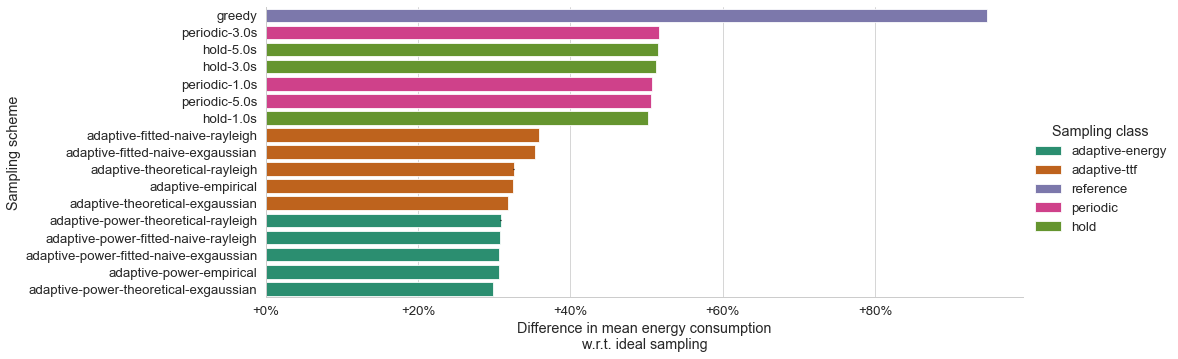

In [91]:
import matplotlib.ticker as tkr

plot_data = energies_maxrtt.reset_index().query("sampling_scheme != 'ideal'")


fg = sns.catplot(
    kind="bar",
    errorbar=None,
    data=plot_data,
    y="sampling_scheme",
    x="mean_diff_ideal_percent",
    aspect=3,
    xerr=plot_data["mean_diff_ideal_95ci_percent"],
    order=plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"],
    hue="sampling_class",
    dodge=False,
)
for ax in fg.axes.flat:
    # pass
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:+0.0%}"))

fg.set_axis_labels("Difference in mean energy consumption\nw.r.t. ideal sampling", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

In [77]:
best_schemes = plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"][-5:]
best_schemes

2       adaptive-power-theoretical-rayleigh
4      adaptive-power-fitted-naive-rayleigh
3    adaptive-power-fitted-naive-exgaussian
0                  adaptive-power-empirical
1     adaptive-power-theoretical-exgaussian
Name: sampling_scheme, dtype: category
Categories (18, object): ['greedy' < 'ideal' < 'adaptive-empirical' < 'adaptive-theoretical-exgaussian' ... 'periodic-5.0s' < 'hold-1.0s' < 'hold-3.0s' < 'hold-5.0s']

In [78]:
results_best = results[np.isin(results["sampling_scheme"], best_schemes)].copy()
results_best["sampling_scheme"] = results_best["sampling_scheme"].cat.remove_unused_categories()
results_best

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,repetition,energy,cumulative_energy,timing_model,sampling_scheme,sampling_class
216000,3.5,1,3.500000,4.671897,8.613833,3.941936,0.441936,2,8.613833,2,34,0.321207,0.321207,empirical-high,adaptive-power-empirical,adaptive-energy
216001,3.5,2,3.941936,2.287335,11.161605,8.874270,5.374270,1,19.775438,3,34,0.263424,0.584632,empirical-high,adaptive-power-empirical,adaptive-energy
216002,3.5,3,8.874270,7.871693,11.465631,3.593938,0.093938,1,31.241069,4,34,0.267984,0.852616,empirical-high,adaptive-power-empirical,adaptive-energy
216003,3.5,4,3.593938,3.697853,11.637441,7.939588,4.439588,1,42.878510,5,34,0.270562,1.123178,empirical-high,adaptive-power-empirical,adaptive-energy
216004,3.5,5,7.939588,8.114139,12.154734,4.040595,0.540595,1,55.033244,6,34,0.278321,1.401499,empirical-high,adaptive-power-empirical,adaptive-energy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575995,1.5,116,3.292619,13.393415,15.726484,2.333069,0.833069,3,1163.274301,180,27,0.343897,23.929115,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy
575996,1.5,117,2.333069,6.851455,11.567141,4.715686,3.215686,2,1174.841442,182,27,0.245507,24.174622,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy
575997,1.5,118,4.715686,7.884110,12.116737,4.232627,2.732627,2,1186.958179,184,27,0.253751,24.428373,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy
575998,1.5,119,4.232627,8.150497,12.116737,3.966239,2.466239,2,1199.074916,186,27,0.253751,24.682124,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy


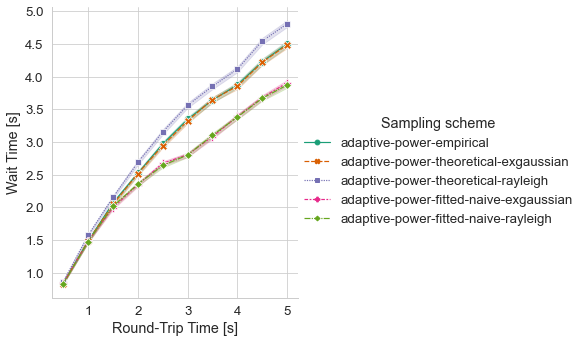

In [101]:
fg = sns.relplot(
    kind="line",
    errorbar=("ci", 95),
    data=results_best,
    x="rtt",
    y="wait_time",
    hue="sampling_scheme",
    style="sampling_scheme",
    markers=True,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Wait Time [s]")
fg.legend.set_title("Sampling scheme")
plt.show()